In [1]:
import pandas as pd                      # pandas is a dataframe library
import matplotlib.pyplot as plt          # matpoltlib.pypolt plots data
import numpy as np                       # numpy provides N-dim object support
import seaborn as sns
from apyori import apriori

from sklearn import model_selection
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer      # importing class imputer to replace zero missing values with mean values 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text  # both are new in 0.21
from sklearn.neighbors import KNeighborsClassifier

from plotly import __version__
from plotly.graph_objs import FigureWidget
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# do plotting inline instead of in a separate window
%matplotlib inline

seed = 42

# Converting strings into integers

In [3]:

def conv_binary(cell):
    if(cell == 'satisfied' or cell == 'Loyal Customer' or cell == 'Male' or cell == 'Personal Travel' or cell == 'Eco'):
        return 1
    elif(cell == 'Eco Plus'):
        return 2
    else:
        return 0

def expandRate(dataf, cell):
    return dataf.merge(dataf[cell].apply(lambda s: pd.Series({'Excellent'+cell: int(s > 3), 'Good'+cell: int(1 < s < 4),'Bad'+cell: int(s < 2)})), 
                        left_index=True, right_index=True)

In [4]:
#loading data
df = pd.read_excel("D:\SMT\SEM2\ASBD\Project\satisfaction.xlsx", converters={
    #"satisfaction_v2" : conv_binary,
    "Gender" : conv_binary,
    "Type of Travel" : conv_binary,
    "Class" : conv_binary,
    "Customer Type" : conv_binary
})

df_assoc = df.copy()

# Descriptive Statistics

In [6]:
# describing the data
df.describe()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,...,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,64940.500000,0.492616,0.816908,39.427957,0.309416,0.593864,1981.409055,2.838597,2.990645,2.851994,...,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129
std,37493.270818,0.499947,0.386743,15.119360,0.462255,0.621378,1027.115606,1.392983,1.527224,1.443729,...,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650
min,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32470.750000,0.000000,1.000000,27.000000,0.000000,0.000000,1359.000000,2.000000,2.000000,2.000000,...,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64940.500000,0.000000,1.000000,40.000000,0.000000,1.000000,1925.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,97410.250000,1.000000,1.000000,51.000000,1.000000,1.000000,2544.000000,4.000000,4.000000,4.000000,...,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,1.000000,1.000000,85.000000,1.000000,2.000000,6951.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [6]:
#shape of data set (rowsxcolumns)
df.shape

(129880, 24)

In [73]:
#extracting data 
df.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,satisfied,0,1,65,1,1,265,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,110278,satisfied,1,1,47,1,0,2464,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,103199,satisfied,0,1,15,1,1,2138,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,47462,satisfied,0,1,60,1,1,623,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,120011,satisfied,0,1,70,1,1,354,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [8]:
#datatypes of attributes of dataset
df.dtypes

id                                     int64
satisfaction_v2                       object
Gender                                 int64
Customer Type                          int64
Age                                    int64
Type of Travel                         int64
Class                                  int64
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure 

In [7]:
#summary of null values in each attribute
df.isnull().sum()

id                                     0
satisfaction_v2                        0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

We can see we have null values in attribute Arrival Delay in Minutes. Here the count of null values is very less compared to total records so we can drop those records

In [8]:
df = df.dropna()   #dropping the tuples with null values
df.isnull().values.any()   #checking for the existence of any null values

False

In [48]:
#the size after removing null values
df.shape

(129487, 24)

# Data Visualization

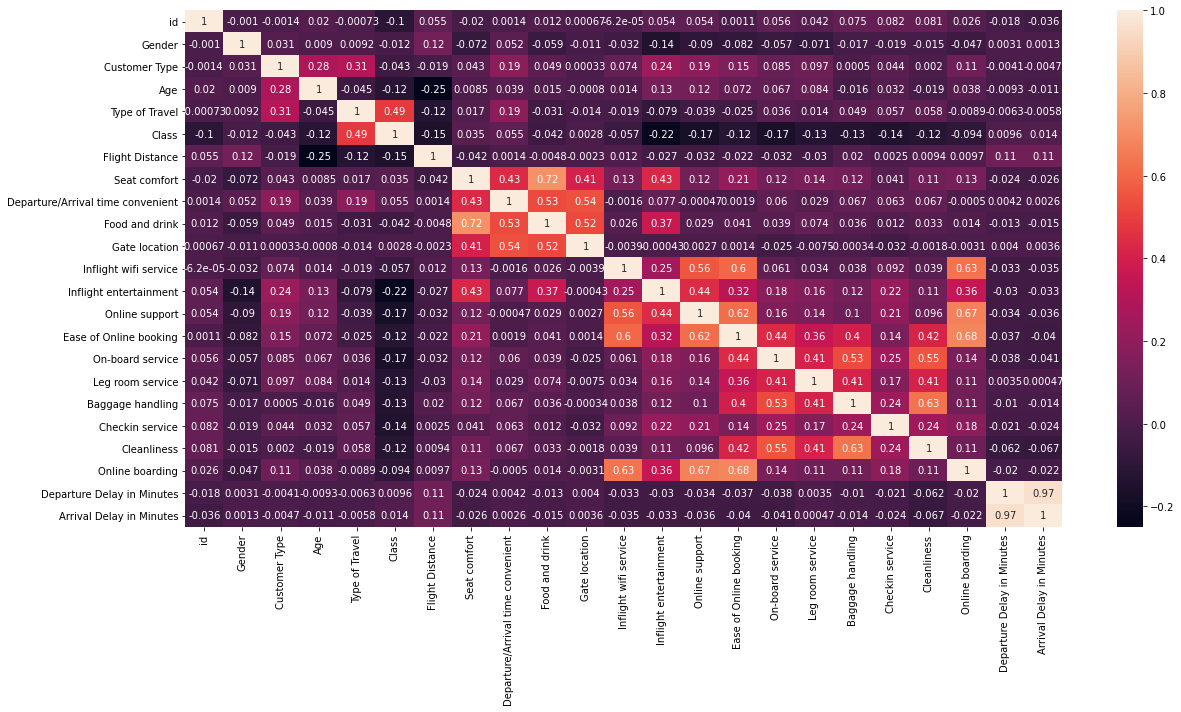

In [20]:
def plot_corr_v2(df):
    fig = plt.figure(figsize=(18,10))
    sns.heatmap(df.corr(),annot=True)
    plt.tight_layout()
plot_corr_v2(df)

In [21]:
#class imbalance
df['satisfaction_v2'].value_counts()

satisfied                  70882
neutral or dissatisfied    58605
Name: satisfaction_v2, dtype: int64

<AxesSubplot:xlabel='satisfaction_v2', ylabel='count'>

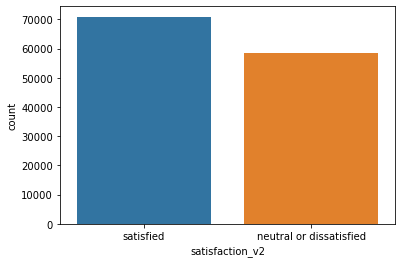

In [22]:
#visualization
sns.countplot(x='satisfaction_v2',data=df)

In [75]:
#Binarizing the class label attribute 'satisfaction_v2'

df['satisfaction_v2'] = df['satisfaction_v2'].apply(conv_binary)

df.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,1,0,1,65,1,1,265,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,110278,1,1,1,47,1,0,2464,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,103199,1,0,1,15,1,1,2138,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,47462,1,0,1,60,1,1,623,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,120011,1,0,1,70,1,1,354,0,0,...,4,2,2,0,2,4,2,5,0,0.0


From the correlation matrix we consider the attributes with threshold value of 0.1 

<AxesSubplot:>

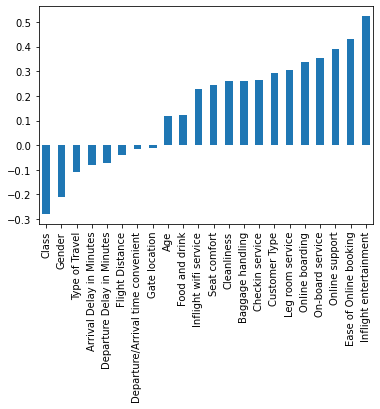

In [24]:
#visualising the attributes above the threshold correlation
df.corr()['satisfaction_v2'].sort_values().drop(['id','satisfaction_v2']).plot(kind='bar')

From the above graph we can see Inflight entertainment is more correlated with the satisfaction attribute. lets now look at the ratings and thier counts.

In [25]:
df['Inflight entertainment'].value_counts()

4    41752
5    29748
3    24133
2    19118
1    11768
0     2968
Name: Inflight entertainment, dtype: int64

We can see maximum people have given a rating of 4 for the inflight entertainment.

<AxesSubplot:ylabel='Frequency'>

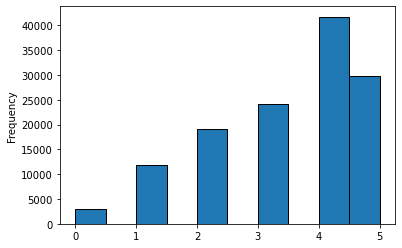

In [26]:
#visualising
df['Inflight entertainment'].plot(kind='hist',ec='black')

<AxesSubplot:xlabel='satisfaction_v2', ylabel='Inflight entertainment'>

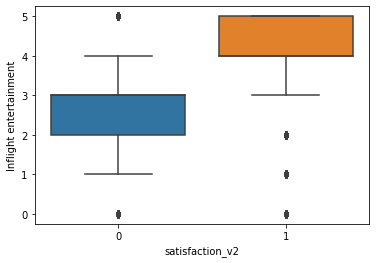

In [27]:
sns.boxplot(x='satisfaction_v2',y = 'Inflight entertainment',data=df)

From the box whisker plot between satisfaction and inflight entertainment we can have a conclusion that the more satisfied the person is with Inflight entertainment then there are greater chances that the person will be satisfied.
Same is the case for all the other correlated parameters.

Now let us check the correlation of inflight entertainment with the other parameters

<AxesSubplot:>

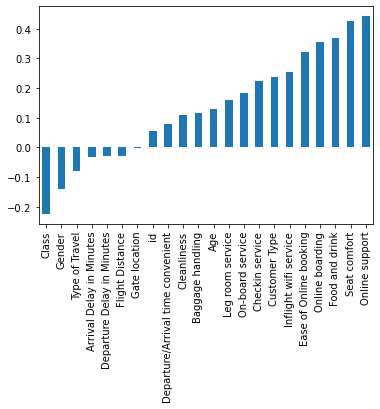

In [28]:
df.corr()['Inflight entertainment'].sort_values().drop(['Inflight entertainment','satisfaction_v2']).plot(kind='bar')

<AxesSubplot:xlabel='Seat comfort', ylabel='Inflight entertainment'>

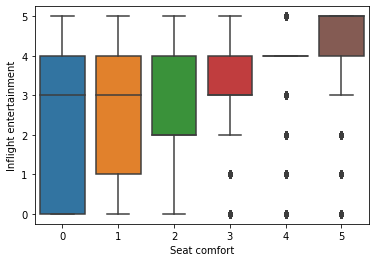

In [29]:
#considering the 'Seat comfort' attribute
sns.boxplot(x='Seat comfort',y = 'Inflight entertainment',data=df)

We can say that people who gets better seat comfort are likely to have good inflight entertainment and gives better rating

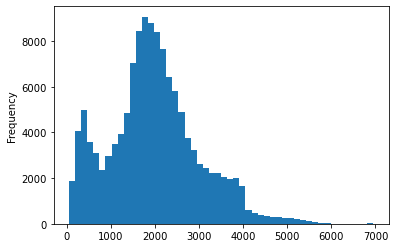

In [31]:
df['Flight Distance'].plot(kind='hist',bins=50)
plt.show()

From the histogram above we can see that most of the flights are between 1000 to 3000 kms, and there are fine number of flights between 200-400 kms

<AxesSubplot:xlabel='Class', ylabel='Age'>

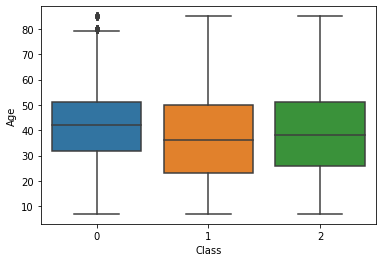

In [20]:
#correlation between type of class and the age 
sns.boxplot(data = df, x="Class", y="Age")

From the boxplot we can infer that people who are sitting in Business class (2) between age 30 to 50 are likely to be more satisfied.

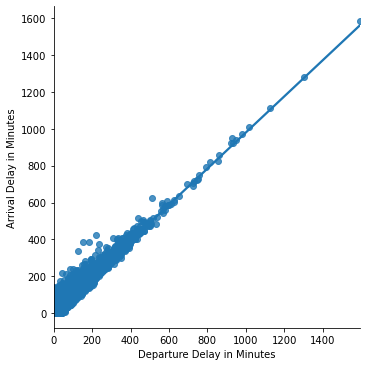

In [50]:
sns.lmplot(x='Departure Delay in Minutes',y='Arrival Delay in Minutes',data=df)

Arrival Delay and Departure delay have a linear relation, so we can drop one column

In [76]:
#dropping columns that are less correlated 
columns = ['Gender', 'Type of Travel', 'Class','Flight Distance', 'Departure/Arrival time convenient', 
           'Gate location', 'Departure Delay in Minutes', 'id', 'Arrival Delay in Minutes']
df.drop(columns, inplace = True, axis=1)

In [59]:
#shape after dropping columns
df.shape

(129487, 15)

In [77]:
#renaming columns for convenience
df.rename(columns={"Food and drink":'FD',"Online boarding":'OB',
                   'Ease of Online booking':'EOOB','Online support':'OS', 'Baggage handling':'BH', 
                   'Customer Type':'Customer_Type',
                   'Seat comfort':'Seat_comfort',
                  'Inflight wifi service':'Inflight_wifi_service',
                  'Inflight entertainment':'Inflight_entertainment',
                  'On-board service':'On_board_service', 'Leg room service':'Leg_room_service',
                  'Checkin service':'Checkin_service'}
          ,inplace=True)

In [78]:
df.head()

,satisfaction_v2,Customer_Type,Age,Seat_comfort,FD,Inflight_wifi_service,Inflight_entertainment,OS,EOOB,On_board_service,Leg_room_service,BH,Checkin_service,Cleanliness,OB
0,1,1,65,0,0,2,4,2,3,3,0,3,5,3,2
1,1,1,47,0,0,0,2,2,3,4,4,4,2,3,2
2,1,1,15,0,0,2,0,2,2,3,3,4,4,4,2
3,1,1,60,0,0,3,4,3,1,1,0,1,4,1,3
4,1,1,70,0,0,4,3,4,2,2,0,2,4,2,5


In [79]:
#checking true or false
num_true = len(df.loc[df['satisfaction_v2'] == True])   # satisfication statuses are true
num_false = len(df.loc[df['satisfaction_v2'] == False]) # satisfication statuses are false

print("Number of True cases: {0} ({1:2.2f}%)".format(num_true,(num_true/ (num_true + num_false)) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false,(num_false/ (num_true + num_false)) * 100))

Number of True cases: 70882 (54.74%)
Number of False cases: 58605 (45.26%)


# Data preparation for classification

In [80]:
feature_col_names = ['Customer_Type', 'Age', 'BH', 
                     'FD', 'Seat_comfort', 'Leg_room_service',
                     'OB','OS','Inflight_wifi_service',
                    'Inflight_entertainment','On_board_service',
                    'Checkin_service','Cleanliness','EOOB']
predicted_class_names = ['satisfaction_v2']


x = df[feature_col_names].values           # predictor feature columns (8 x m)
y = df[predicted_class_names].values       # predictor class (1 = true , 0 = false) column (1 x m)
split_test_size = 0.30

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_test_size, random_state=seed, stratify=y)

models = []
names = []
results = []

print("{0:0.2f}% in training set".format((len(x_train)/len(df.index))*100))
print("{0:0.2f}% in test set".format((len(x_test)/len(df.index))*100))

70.00% in training set
30.00% in test set


In [81]:
print("Original True : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 1]), (len(df.loc[df['satisfaction_v2'] == 1]) / len(df.index))*100))
print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 0]), (len(df.loc[df['satisfaction_v2'] == 0]) / len(df.index))*100))
print("")
print("Training True : {0} ({1:0.3f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1]) / len(y_train) * 100.0 )))
print("Training False : {0} ({1:0.3f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0]) / len(y_train) * 100.0 )))
print("")
print("Test True : {0} ({1:0.3f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1]) / len(y_test) * 100.0 )))
print("Test False : {0} ({1:0.3f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0]) / len(y_test) * 100.0 )))

fill_0 = SimpleImputer(missing_values=0, strategy="mean", verbose=0)  # axis=0 -> col, verbose = axis

x_train = fill_0.fit_transform(x_train)
x_test = fill_0.fit_transform(x_test)

Original True : 70882 (54.74%)
Original False : 58605 (45.26%)

Training True : 49617 (54.741%)
Training False : 41023 (45.259%)

Test True : 21265 (54.740%)
Test False : 17582 (45.260%)


# Naive Bayes Classification

In [82]:
categorical_feature_col_names = ['Customer_Type', 'BH', 
                     'FD', 'Seat_comfort', 'Leg_room_service',
                     'OB','OS','Inflight_wifi_service',
                    'Inflight_entertainment','On_board_service',
                    'Checkin_service','Cleanliness','EOOB']
predicted_class_names = ['satisfaction_v2']


x_cat = df[categorical_feature_col_names].values           # predictor feature columns (8 x m)
y = df[predicted_class_names].values       # predictor class (1 = true , 0 = false) column (1 x m)
split_test_size = 0.30

x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_cat, y, test_size=split_test_size, random_state=seed, stratify=y)

print("{0:0.2f}% in training set".format((len(x_train_cat)/len(df.index))*100))
print("{0:0.2f}% in test set".format((len(x_test_cat)/len(df.index))*100))

70.00% in training set
30.00% in test set


In [83]:

print("Original True : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 1]), (len(df.loc[df['satisfaction_v2'] == 1]) / len(df.index))*100))
print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['satisfaction_v2'] == 0]), (len(df.loc[df['satisfaction_v2'] == 0]) / len(df.index))*100))
print("")
print("Training True : {0} ({1:0.3f}%)".format(len(y_train_cat[y_train_cat[:] == 1]), (len(y_train_cat[y_train_cat[:] == 1]) / len(y_train_cat) * 100.0 )))
print("Training False : {0} ({1:0.3f}%)".format(len(y_train_cat[y_train_cat[:] == 0]), (len(y_train_cat[y_train_cat[:] == 0]) / len(y_train_cat) * 100.0 )))
print("")
print("Test True : {0} ({1:0.3f}%)".format(len(y_test_cat[y_test_cat[:] == 1]), (len(y_test_cat[y_test_cat[:] == 1]) / len(y_test_cat) * 100.0 )))
print("Test Fasle : {0} ({1:0.3f}%)".format(len(y_test_cat[y_test_cat[:] == 0]), (len(y_test_cat[y_test_cat[:] == 0]) / len(y_test_cat) * 100.0 )))

Original True : 70882 (54.74%)
Original False : 58605 (45.26%)

Training True : 49617 (54.741%)
Training False : 41023 (45.259%)

Test True : 21265 (54.740%)
Test Fasle : 17582 (45.260%)


In [84]:
models = []
names = []
results = []
#Impute with mean all 0 readings
fill_0 = SimpleImputer(missing_values=0, strategy="mean", verbose=0)  # axis=0 -> col, verbose = axis

x_train_cat = fill_0.fit_transform(x_train_cat)
x_test_cat = fill_0.fit_transform(x_test_cat)

# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(x_train_cat,y_train_cat.ravel());

models.append(nb_model)
names.append("NB")

# predict values using the training data
nb_predict_train = nb_model.predict(x_train_cat)

acc_train = metrics.accuracy_score(y_train_cat, nb_predict_train)

# predict values using the test data
nb_predict_test = nb_model.predict(x_test_cat)

acc_test = metrics.accuracy_score(y_test_cat, nb_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 79.63%
Accuracy on testing data: 79.49%


Confucsion Matrix
[[13332  4250]
 [ 3717 17548]]

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     17582
           1       0.81      0.83      0.81     21265

    accuracy                           0.79     38847
   macro avg       0.79      0.79      0.79     38847
weighted avg       0.79      0.79      0.79     38847



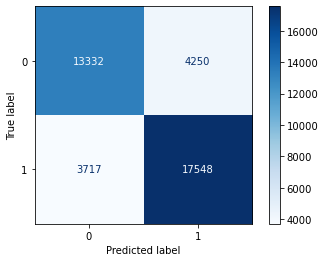

In [85]:
#confusion matrix
confM = metrics.plot_confusion_matrix(nb_model, x_test_cat, y_test_cat, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test_cat, nb_predict_test))

# Random Forest Classification

In [86]:
# Create random forest object
rf_model = RandomForestClassifier(random_state=seed, n_estimators=10)  # n_estimators will change from 10 in version 0.20 to 100 in 0.22
rf_model.fit(x_train, y_train.ravel());

models.append(rf_model)
names.append("RF")

# predict values using the training data
rf_predict_train = rf_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, rf_predict_train)

# predict values using the test data
rf_predict_test = rf_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, rf_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 99.42%
Accuracy on testing data: 92.84%


Confucsion Matrix
[[16438  1144]
 [ 1638 19627]]

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     17582
           1       0.94      0.92      0.93     21265

    accuracy                           0.93     38847
   macro avg       0.93      0.93      0.93     38847
weighted avg       0.93      0.93      0.93     38847



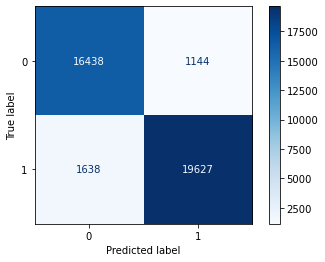

In [87]:
#confusion matrix
confM = metrics.plot_confusion_matrix(rf_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

# Decision Tree Classification

In [88]:

# Create Decision Tree object
dt_model = DecisionTreeClassifier(random_state=seed, max_depth=10)
dt_model.fit(x_train, y_train.ravel());

models.append(dt_model)
names.append("DT")

# predict values using the training data
dt_predict_train = dt_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, dt_predict_train)

# predict values using the test data
dt_predict_test = dt_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, dt_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 91.50%
Accuracy on testing data: 90.66%


Confucsion Matrix
[[15705  1877]
 [ 1750 19515]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     17582
           1       0.91      0.92      0.91     21265

    accuracy                           0.91     38847
   macro avg       0.91      0.91      0.91     38847
weighted avg       0.91      0.91      0.91     38847



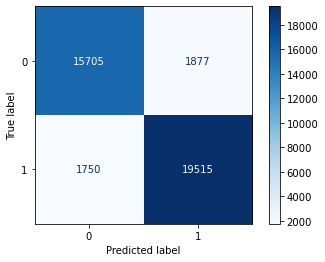

In [89]:
# plot confusion matrix
confM = metrics.plot_confusion_matrix(dt_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, dt_predict_test))

# K-Nearest Neighbours Classifier

In [90]:

# Create KNeighbors object
knn_model = KNeighborsClassifier() # weights = 'distance' make the training accuracy 100% but doesn't make difference on testing data
knn_model.fit(x_train, y_train.ravel());

models.append(knn_model)
names.append("KNN")
# predict values using the training data
knn_predict_train = knn_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, knn_predict_train)

# predict values using the test data
knn_predict_test = knn_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, knn_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 91.29%
Accuracy on testing data: 87.44%


Confucsion Matrix
[[15575  2007]
 [ 2873 18392]]

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86     17582
           1       0.90      0.86      0.88     21265

    accuracy                           0.87     38847
   macro avg       0.87      0.88      0.87     38847
weighted avg       0.88      0.87      0.87     38847



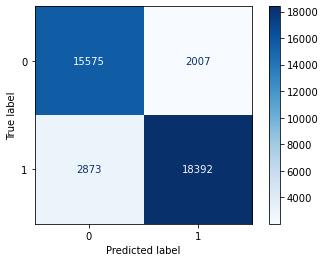

In [91]:
# plot confusion matrix
confM = metrics.plot_confusion_matrix(knn_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, knn_predict_test))

# Logistic Regression Classification

In [92]:
# Create LogisticRegression object
lr_model = LogisticRegression(random_state=seed, max_iter=10000) 
lr_model.fit(x_train, y_train.ravel());

models.append(lr_model)
names.append("LR")

# predict values using the training data
lr_predict_train = lr_model.predict(x_train)

acc_train = metrics.accuracy_score(y_train, lr_predict_train)

# predict values using the test data
lr_predict_test = lr_model.predict(x_test)

acc_test = metrics.accuracy_score(y_test, lr_predict_test)

results.append((acc_train, acc_test))

#Accuracy
print("Accuracy on training data: {:.2%}".format(acc_train)) # accuracy on training data
print("Accuracy on testing data: {:.2%}".format(acc_test)) # accuracy on testing data

Accuracy on training data: 82.03%
Accuracy on testing data: 81.95%


Confucsion Matrix
[[13694  3888]
 [ 3125 18140]]

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.78      0.80     17582
           1       0.82      0.85      0.84     21265

    accuracy                           0.82     38847
   macro avg       0.82      0.82      0.82     38847
weighted avg       0.82      0.82      0.82     38847



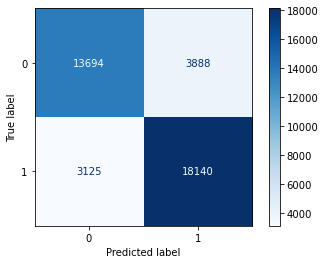

In [93]:
# plot confusion matrix
confM = metrics.plot_confusion_matrix(lr_model, x_test, y_test, cmap='Blues', values_format='d')
print("Confucsion Matrix")
print(confM.confusion_matrix)
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

# Comparing accuracies of Classifiers

NB: 0.796293 (0.004593)
RF: 0.927526 (0.002206)
DT: 0.906520 (0.001548)
KNN: 0.876015 (0.004240)
LR: 0.820267 (0.004976)


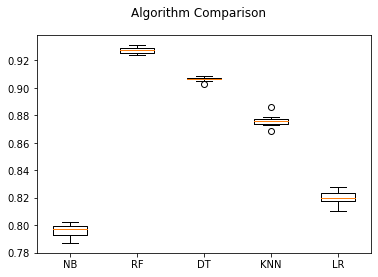

In [94]:
results_ = []
scoring = 'accuracy'
for i, model in enumerate(models):
    kfold = model_selection.KFold(n_splits=10)
    cv_results = None
    if not i:
        cv_results = model_selection.cross_val_score(models[0], x_train_cat, y_train_cat.ravel(), cv=kfold, scoring=scoring)
        results_.append(cv_results)
    else:
        cv_results = model_selection.cross_val_score(model, x_train, y_train.ravel(), cv=kfold, scoring=scoring)
        results_.append(cv_results)
    msg = "%s: %f (%f)" % (names[i], cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_)
ax.set_xticklabels(names)
plt.show()

# Visualising Actual vs Predicted dataset

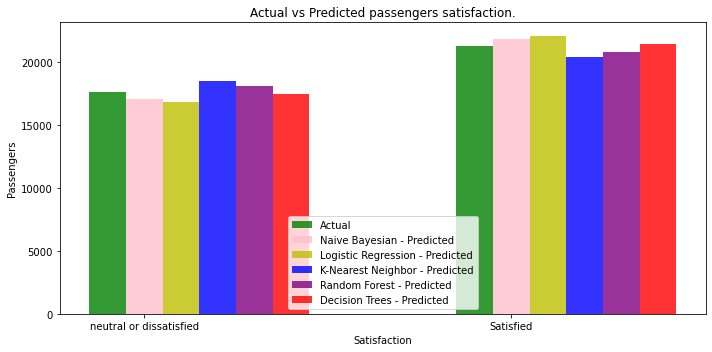

In [97]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(knn_predict_test, return_counts=True)
frequency_predicted_knn = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(dt_predict_test, return_counts=True)
frequency_predicted_dt = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(rf_predict_test, return_counts=True)
frequency_predicted_rf = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(lr_predict_test, return_counts=True)
frequency_predicted_lr = (occurCount[0], occurCount[1])

uniqueValues, occurCount = np.unique(nb_predict_test, return_counts=True)
frequency_predicted_nb = (occurCount[0], occurCount[1])


n_groups = 2
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')
rects2 = plt.bar(index + bar_width, frequency_predicted_nb, bar_width,
alpha=opacity,
color='pink',
label='Naive Bayesian - Predicted')

rects3 = plt.bar(index + bar_width*2, frequency_predicted_lr, bar_width,
alpha=opacity,
color='y',
label='Logistic Regression - Predicted')

rects4 = plt.bar(index + bar_width*3, frequency_predicted_knn, bar_width,
alpha=opacity,
color='b',
label='K-Nearest Neighbor - Predicted')

rects5 = plt.bar(index + bar_width*4, frequency_predicted_rf, bar_width,
alpha=opacity,
color='purple',
label='Random Forest - Predicted')

rects6 = plt.bar(index + bar_width*5, frequency_predicted_dt, bar_width,
alpha=opacity,
color='red',
label='Decision Trees - Predicted')

plt.xlabel('Satisfaction')
plt.ylabel('Passengers')
plt.title('Actual vs Predicted passengers satisfaction.')
plt.xticks(index + bar_width, ('neutral or dissatisfied', 'Satisfied'))
plt.legend()

plt.tight_layout()
plt.show()